In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time


def gen_init_state(L, state_name:str='bipartite_state', spin:str='spinless', filled=None):
    """
    生成半填充的实空间初态
    
    依据
    `Cor_{ij} = < c^\\dagger_i c_j > = \\sum_{\\alpha} \\phi^*_\\alpha (i) \\phi_\\alpha (j) `  # 但是其实后面算Cor的时候，复共轭在后者而不是前者  # 这是个厄米矩阵，复共轭不影响本征值，只会改变本征矢量
    """
    if not filled is None:
        init_state = np.zeros((L, len(filled)), dtype=np.complex128)
        for i, idx in enumerate(filled):
            init_state[idx, i] = 1
        return init_state

    if spin == 'spinless':
        length = L
        dis = 1
        start = 0
    elif spin == 'up':
        length = 2 * L
        dis = 2
        start = 1
    elif spin == 'down':
        length = 2 * L
        dis = 2
        start = 0
    init_state = np.zeros((length, length // 2 // dis), dtype=np.complex128)
    if state_name == 'bipartite_state':
        for i in range(length // 2 // dis):
            init_state[start + i * dis, i] = 1
    elif state_name == 'neel_state':
        for i in range(length // 2 // dis):
            init_state[start + i * 2 * dis, i] = 1
    else:
        print("Error! ")
        return
    return init_state

# print(gen_init_state(10, 'neel_state'))

def evol_sys(psi_init, H_evo, t):
    psi_t = expm( - 1j * H_evo * t) @ psi_init
    return psi_t

def cal_entropy(system_psi, subsys):
    """
    subsys: np.array
    """
    Cor = system_psi @ system_psi.conj().T
    Cor_subsys = Cor[subsys, :][:, subsys]
    xi, _ = np.linalg.eig(Cor_subsys)
    ee = np.nansum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(subsys)
    return ee


Mz = 0.00 (1 / 17)


C:\Users\user\AppData\Local\Temp\ipykernel_13372\1790787120.py:58: RuntimeWarning: divide by zero encountered in log
  ee = np.nansum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(subsys)
C:\Users\user\AppData\Local\Temp\ipykernel_13372\1790787120.py:58: RuntimeWarning: invalid value encountered in multiply
  ee = np.nansum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(subsys)


Mz = 0.25 (2 / 17)
Mz = 0.50 (3 / 17)
Mz = 0.75 (4 / 17)
Mz = 1.00 (5 / 17)
Mz = 1.25 (6 / 17)
Mz = 1.50 (7 / 17)
Mz = 1.75 (8 / 17)
Mz = 2.00 (9 / 17)
Mz = 2.25 (10 / 17)
Mz = 2.50 (11 / 17)
Mz = 2.75 (12 / 17)
Mz = 3.00 (13 / 17)
Mz = 3.25 (14 / 17)
Mz = 3.50 (15 / 17)
Mz = 3.75 (16 / 17)
Mz = 4.00 (17 / 17)


d:\anaconda3\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


elapsed time: 315.5 s


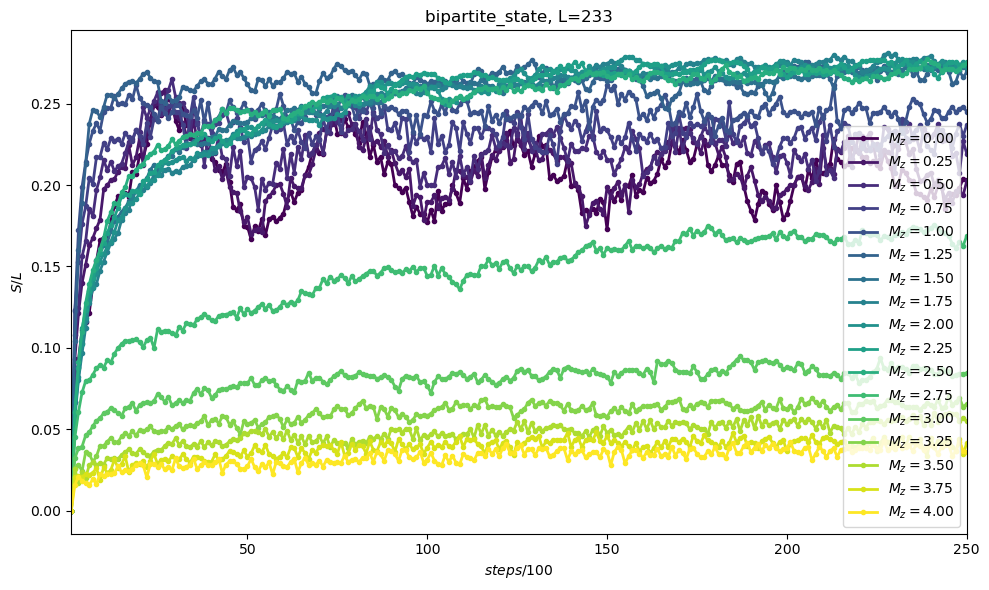

In [63]:
model_name = "Raman"

def fibonacci(n):
    if not(type(n) == int) or n < 0:
        return
    if n == 0 or n == 1:
        return 1
    else:
        f = fibonacci(n-1) + fibonacci(n-2)
        return f
# F14 = 610

def gen_H_Raman_real(L, tso, Mz, beta, t0=1, phi=0):
    Ham = np.zeros((2 * L, 2 * L), dtype=np.complex128)
    
    for i in range(L - 1):
        Ham[2 * i + 2, 2 * i] = t0  # 0, 2, 4, ... down
        Ham[2 * i + 3, 2 * i + 1] = - t0  # 1, 3, 5, ... up
        Ham[2 * i + 1, 2 * i + 2] = tso
        Ham[2 * i + 3, 2 * i] = - tso

    Ham[0, 2 * (L - 1)] = t0  # PBC条件
    Ham[1, 2 * (L - 1) + 1] = - t0
    Ham[2 * (L - 1) + 1, 0] = tso
    Ham[1, 2 * (L - 1)] = - tso

    Ham += Ham.conj().T  # 加上H.c.
    for i in range(L):  # 准周期势
        Ham[2 * i, 2 * i] = - Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)  # 下标从0开始，但是格点从1开始，所以i + 1
        Ham[2 * i + 1, 2 * i + 1] = Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)

    return Ham


def cal_S_of_t(L, tso, Mz_array, beta, steps, dt, t0=1, phi=0):
    S_array = np.zeros((len(Mz_array), steps), dtype=np.complex128)
    sub_system = np.arange(2 * L // 2)
    if state_name == "bipartite_state":
        filled_indices = np.arange(1, 2 * L // 2, 2)  # 只填前一半的上自旋态
    elif state_name == "neel_state":
        filled_indices = np.arange(1, 2 * L, 4)  # 交错填充上自旋态，总的只填 L/2 个电子

    for i, Mz in enumerate(Mz_array):
        print(f"Mz = {Mz:.2f} ({i + 1} / {len(Mz_array)})")
        H_evo = gen_H_Raman_real(L, tso, Mz, beta, t0, phi)
        system = gen_init_state(2 * L, filled=filled_indices)

        for j in range(steps):
            S_array[i, j] = cal_entropy(system, sub_system)
            system = evol_sys(system, H_evo, dt)

    file_name = f"S_{model_name}_{state_name}_L_{L}_Mz_{Mz_array[0]}_{Mz_array[-1]}_steps_{steps}_dt_{dt}"
    np.savez("data/" + file_name + ".npz", S_array=S_array)


def vis_S_of_t(L, Mz_array, steps, dt):
    file_name = f"S_{model_name}_{state_name}_L_{L}_Mz_{Mz_array[0]}_{Mz_array[-1]}_steps_{steps}_dt_{dt}"
    data = np.load("data/" + file_name + ".npz")
    S_array = data["S_array"]

    colors = plt.cm.viridis(np.linspace(0, 1, len(Mz_array)))
    plt.figure(figsize=(10, 6))
    for i, Mz in enumerate(Mz_array):
        plt.plot(np.arange(1, steps+1e-3), S_array[i, :], marker=".", linewidth=2, label=r"$M_z=%.2f$" % (Mz), color=colors[i])
    
    plt.title(rf"{state_name}, L={L}")
    plt.legend(loc='lower right')
    plt.xlabel(rf"$steps/{dt}$")
    plt.xlim(1, steps)
    plt.ylabel(r"$S/L$")
    plt.tight_layout()
    plt.savefig("fig/" + file_name + ".png", dpi=300, bbox_inches="tight")


if __name__ == "__main__":
    np.random.seed(123)
    state_name = "bipartite_state"
    L = fibonacci(12)  #
    t0 = 1
    tso = 0.3
    # Mz_array = np.concatenate((np.arange(0, 0.5, 0.25), np.arange(0.5, 1.5, 0.1), np.arange(1.5, 2.0+1e-3, 0.25)))
    Mz_array = np.arange(0, 4 + 0.001, 0.25)
    beta = fibonacci(11) / fibonacci(12)  #
    phi = 0
    steps = 250
    dt = 100
    
    # import os
    # if not os.path.exists('data'):
    #     os.mkdir('data')  # 创建文件夹
    # if not os.path.exists('fig'):
    #     os.mkdir('fig')
    # del os

    start_time = time.time()
    cal_S_of_t(L, tso, Mz_array, beta, steps, dt, t0, phi)
    vis_S_of_t(L, Mz_array, steps, dt)
    end_time = time.time()
    print(f"elapsed time: {end_time - start_time:.1f} s")